In [91]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
#import lightkurve
#from lightkurve.lightcurve import LightCurve
#astropy.units as u
#astropy.constants as c

# Bayes' Theorem:

# $P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(B)}$

---

# P($\theta$|D) is the posterior
- the probability of a set of model parameters ($\theta$) given our data (D).

# P(D|$\theta$) is the likelihood
- how well a given model with parameters, $\theta$, fits the data.

# P($\theta$) is the prior
- our prior belief in the model parameters. This is usually based on what boundaries you think are physically reasonable for the system. Priors can be uniform (equal probability for all parameter values), gaussian, poisson, etc 

# P(D) is a normalization factor
- usually this is very difficult or impossible to calculate, so we marginalize over it

---


When we are using Bayesian statistics in our MCMC, it is helpful to take the log of this expression:

# $log(posterior) = log(likelihood) + log(prior) - log(normalization)$
so that we can deal with simpler math

---

# Markov-Chain Monte Carlo

This notebook isn't explicitly aiming to cover all of the fundamental statistics beneath emcee or model fitting in general, so I recommend you read [these](https://arxiv.org/pdf/1202.3665.pdf) [papers](https://arxiv.org/abs/1008.4686).

MCMC is a process by which you can sample the "true" posterior distribution of parameter space as it is explored by "walkers". Basically your multi-dimensional probability space (let's say radius, mid-transit time, and flux baseline for an exoplanet transit) is populated with some number of "walkers" that explore the space and calculate a prior and a likelihood for each set of model parameters. The walker examines the probability of those model parameters and then makes a stochastic jump to a new set of parameters and examines how the new parameters compare. By doing this stochastically, that is, with an element of randomness determining where the walker moves to next, you can create a sample of the posterior distribution of your parameters and therefore fit a model to your data.

---

# emcee, The MCMC Hammer

emcee is the algorithm package which helps us to run these complicated multi-dimensional explorations of probabiltiy space by only having to tune a few parameters. It is an affine invariant ensemble sampler for Markov chain Monte Carlo. 

Affine Invariant means this algorithm performs equally well under all linear transformations and is therefore insensitive to covariances among parameters.

---

# Now, let's simulate some transit data...

Say we are observing a transit of a planet with the following properties:

rp = 1 Rearth

rs = 0.2 Rsun

period = 10 days

In [43]:
def BATMAN_MODEL(baseline, rp, t0=0, rs = 0.2, period = 10.0,  t = None):
    
    rp_rs = (rp/rs)*(1/109) #conversion from rearth and rsun to into unitless rp/r* using earth-sun ratio 
    
    params = batman.TransitParams()
    params.t0 = t0                      #time of inferior conjunction
    params.per = period*24.0                 #period in hours
    params.rp = rp_rs                   #planet radius (in units of stellar radii)
    params.a = 90                       #semi-major axis (in units of stellar radii)
    params.inc = 90                     #orbital inclination (in degrees)
    params.ecc = 0                      #eccentricity
    params.w = 90                       #longitude of periastron (in degrees)
    params.u = [0.1956, 0.3700]         #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"      #limb darkening model
        
    m = batman.TransitModel(params, t)    #initializes model
    
    flux = m.light_curve(params)*baseline       #calculates light curve
    
    return flux

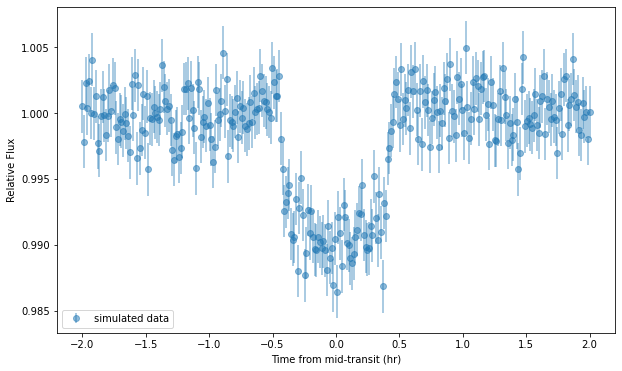

In [77]:
# set up a time array which is 6 hours long
start_hr = -2.0
stop_hr = 2.0
length = 300
times = np.linspace(start_hr,stop_hr,length)

# Now using the batman package, we can simulate an idealized transit
sim_data = BATMAN_MODEL(baseline = 1.0, rp = 2.0, t0=0, t = times)
noise = 0.002 # 2ppt noise, about what I can get with LCO 1m observations
scatter = np.random.normal(0,noise,length)

data = sim_data + scatter
err = np.linspace(0.002,0.002,length)

plt.figure(figsize=(10,6))
plt.errorbar(times,data,yerr=err,zorder=10000,alpha=0.5,label='simulated data',fmt='o')
plt.legend(loc='lower left')
plt.xlabel('Time from mid-transit (hr)')
plt.ylabel('Relative Flux')
plt.show()

# Now before we start using Emcee, let's define a log posterior function, using a Gaussian likelihood and uniform priors

In [78]:
def lnprob(parameters, plot=False):
        
    # pull out some model parameters
    Baseline, Rp, t0 = parameters
    
    model_flux = BATMAN_MODEL(Baseline, Rp, t0, t = times)
    
    if plot:
        plt.errorbar(times,data,yerr=err,fmt='o',alpha = 0.5,label='Simulated Data')
        plt.plot(times,model_flux,label='MCMC Model',color='k',zorder=100)
        plt.xlabel('Hours from Mid-Transit')
        plt.ylabel('Flux')
        
        plt.legend(frameon=False)    
        plt.savefig('LightCurve_Simulation.pdf')   
        plt.show()
        
    
    # here I'll use the simpler case of uniform priors, in effect saying that we have no assumptions about the parameters
    # we will, however, put some hard limits on parameter space when calculating our log likelihoods
    
    if (0.0 < Baseline) and (0.0 <= Rp) and (-2.0 < t0 < 2.0 ):
        chisq = np.sum((data - model_flux)**2/(err)**2)
        lnp = np.sum(1/np.sqrt(2*np.pi*(err))) - 0.5*chisq #this is a gaussian likelihood
    
        return lnp
    
    return -np.inf

Test that the lnprob, with a given set of (true) parameters, returns the expected model.

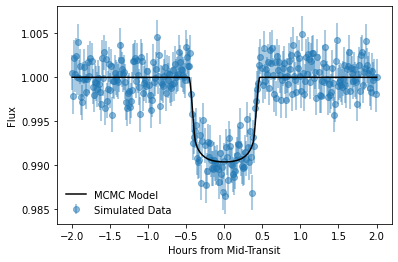

2552.0853867310216

In [79]:
params = [1.0,2.0,0.0] # [baseline, rp, t0]

lnprob(params,plot=True)

In [80]:
# intialize some walkers
ndim, nwalkers, nsteps = 3, 100, 1000

# these are initial parameters
baseline_init = np.random.uniform(0.5, 1.5, nwalkers)
rp_init = np.random.uniform(0, 4, nwalkers)
t0_init = np.random.uniform(-0.05, 0.05, nwalkers)

p0 = np.transpose([baseline_init, rp_init, t0_init])

In [81]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

In [82]:
burnin = int(0.1*nsteps) # let's toss out the first 10% of samples as the "burn-in"
Base, Rp, t0 = sampler.chain.T
Base_trimmed, Rp_trimmed, t0_trimmed = sampler.chain.T[:, burnin:nsteps, :]

baseline_samples = Base_trimmed.flatten()
rp_samples = Rp_trimmed.flatten()
t0_samples = t0_trimmed.flatten()

# Let's plot our data and some random samples from the sampler to see how well the MCMC worked!

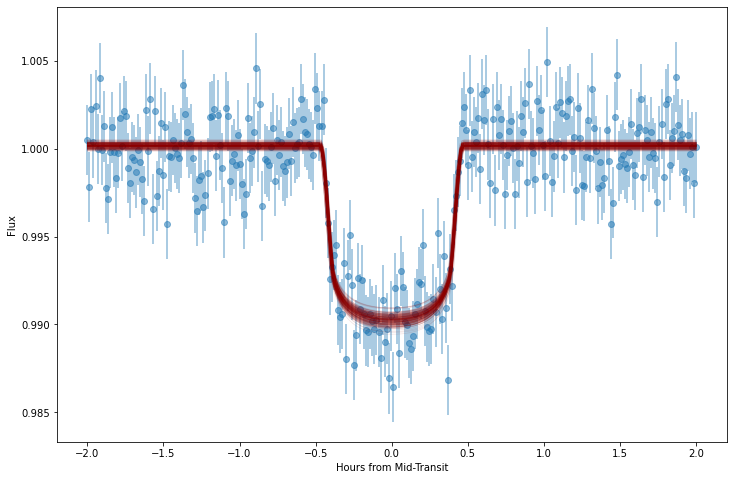

In [90]:
plt.figure(figsize=(12,8))
plt.errorbar(times,data,yerr=err,fmt='o',alpha = 0.5,label='Simulated Data')
plt.xlabel('Hours from Mid-Transit')
plt.ylabel('Flux')

#########################################
# Plot 200 random models from the samples
#########################################
    
for j in range(0,200,1):
    i = np.random.randint(low=0,high=(nsteps-trim)*nwalkers)
    sampled_model = BATMAN_MODEL(baseline = baseline_samples[i], rp = rp_samples[i], t0 = t0_samples[i],t = times)
    plt.plot(times,sampled_model,color='darkred',alpha = 0.1,
            linewidth=0.8,zorder=100)

plt.show()

In [84]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(4,2, hspace=0.6)
    
    #Walker Plots
    ax_Base = plt.subplot(gs[0,0])
    ax_Base.plot(Base.flatten()[::nwalkers],color='black',alpha=0.5); 
    ax_Base.axvspan(start, stop, zorder=-1,alpha=0.3); 
    ax_Base.set_ylabel('Baseline Flux')
    
    ax_Rp = plt.subplot(gs[0,1], sharex=ax_Base)
    ax_Rp.plot(Rp.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    ax_t0 = plt.subplot(gs[1,0], sharex=ax_Base)
    ax_t0.plot(t0.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_t0.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_t0.set_ylabel('Mid-Transit Time (hr)')
    
    #Histograms
    ax_Basehist = plt.subplot(gs[1,1])
    ax_Basehist.hist(Base.flatten(),color='black',bins=60)
    ax_Basehist.axvline(1.0,zorder=100,color='purple')
    ax_Basehist.set_xlabel('Baseline')
    
    ax_Rphist = plt.subplot(gs[2,0])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=60)
    ax_Rphist.set_xlabel('Rp')
    
    ax_t0hist = plt.subplot(gs[2,1])
    ax_t0hist.hist(t0.flatten(),color='black',bins=60)
    ax_t0hist.set_xlabel('Mid-Transit')

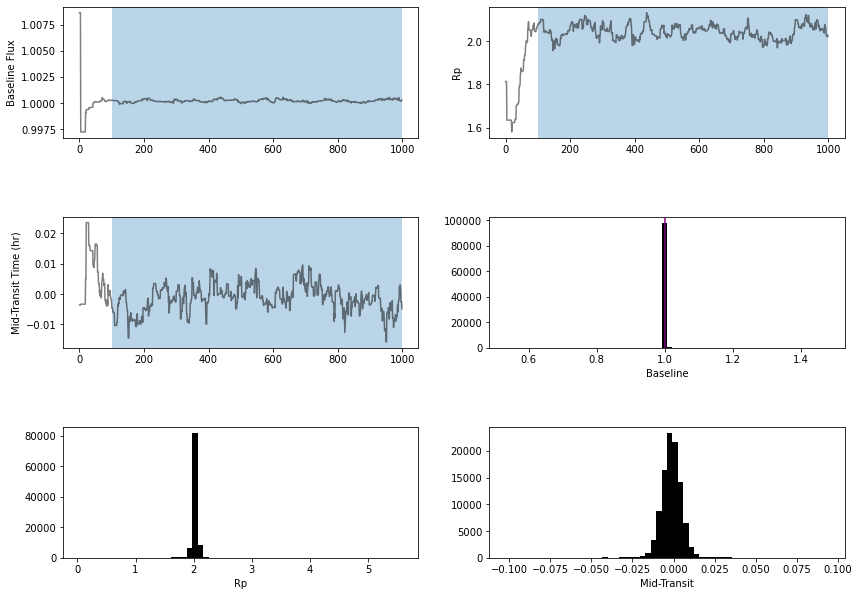

In [85]:
plot_chain(burnin,nsteps)